<a href="https://colab.research.google.com/github/Rudra-prasad-tarai/CreditRiskOptimisation/blob/main/Credit_Risk_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Credit Risk Optimisation using Linear Programming

In [115]:
!git clone https://github.com/Rudra-prasad-tarai/CreditRiskOptimisation
!pip install odfpy

fatal: destination path 'CreditRiskOptimisation' already exists and is not an empty directory.


In [116]:
# imported necesarry Libraries
import pandas as pd
import numpy  as np
from tqdm import tqdm
import re
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, List

# Data Refining and preprocessing

Data for transition matrix is collected from [CRISIL](https://www.crisilratings.com/content/dam/crisil/our-analysis/publications/default-study/crisil-ratings-annual-default-and-ratings-transition-study-fy-2024.pdf), Indian bond data from [NSE](https://www.nseindia.com/market-data/bonds-traded-in-capital-market),.



In [117]:
# transition matrix
transition_matrix = pd.read_excel(
    '/content/CreditRiskOptimisation/data/CrisilTransitionMatrix.ods',
    engine='odf',
    skipfooter=2,          # Excludes last 2 rows
    index_col=0            # Uses 1st column as row labels (index)
)

In [118]:
bonds = pd.read_csv('/content/CreditRiskOptimisation/data/MW-Bonds-on-CM-18-Apr-2025.csv')


In [119]:
# checking if their is an null value
bonds.isnull().sum()

,0
SYMBOL \n,0
SERIES \n,15
BOND TYPE \n,118
COUPON RATE \n,0
FACE VALUE \n,0
LTP \n,0
%CHNG \n,0
VOLUME \n(Shares),0
VALUE \n (₹ Crores),0
\n,398


In [120]:
# Deleting those bonds which does not have crisil rating
del bonds[bonds.columns[8]] # deleting irrlevant column
bonds.dropna(subset = ['CREDIT RATING \n'],inplace=True) #removed those who does not have any rating
print(bonds.columns)

Index(['SYMBOL \n', 'SERIES \n', 'BOND TYPE \n', 'COUPON RATE \n',
       'FACE VALUE \n', 'LTP \n', '%CHNG \n', 'VOLUME \n(Shares)', ' \n',
       'CREDIT RATING \n', 'MATURITY DATE \n'],
      dtype='object')


In [121]:
# Extract ONLY CRISIL ratings (case-insensitive, handles variations)
bonds['CREDIT RATING \n'] = bonds['CREDIT RATING \n'].str.extract(r'(CRISIL\s*[A-Za-z+-]+\s*[A-Za-z]*)', flags=re.IGNORECASE)

# Set non-CRISIL entries to NaN
bonds.loc[~bonds['CREDIT RATING \n' ].str.contains('CRISIL', na=False, case=False), 'CREDIT RATING'] = pd.NA

# Preprocessing
bonds['VOLUME \n(Shares)'] = bonds['VOLUME \n(Shares)'].str.replace('-', '0')
bonds['VOLUME \n(Shares)'] = bonds['VOLUME \n(Shares)'].str.replace(',', '').astype(int)  # or `float`
bonds['FACE VALUE \n'] = bonds['FACE VALUE \n'].str.replace('-', '0')
bonds['FACE VALUE \n'] = bonds['FACE VALUE \n'].str.replace(',', '').astype(float)
bonds['COUPON RATE \n'] = bonds['COUPON RATE \n'].str.replace('-', '0')
bonds['COUPON RATE \n'] = bonds['COUPON RATE \n'].str.replace(',', '').astype(float)   # or `float`



In [122]:
bonds['CREDIT RATING \n']

,CREDIT RATING \n
0,CRISIL AAA STABLE
1,CRISIL AAA STABLE
2,CRISIL AA Stable
3,CRISIL AAA STABLE
4,CRISIL AA Negative
...,...
388,CRISIL AA
389,CRISIL AA
390,CRISIL AA
391,CRISIL AA


In [123]:
bonds.dropna(subset = ['CREDIT RATING \n'],inplace=True)

In [124]:
# from google.colab import files
# df = bonds['CREDIT RATING \n']
# df.to_csv('dat.csv')
# files.download('dat.csv')

In [125]:
bonds['CREDIT RATING \n'].unique()

array(['CRISIL AAA STABLE', 'CRISIL AA Stable', 'CRISIL AA Negative',
       'CRISIL AA-Positive ', 'CRISIL A', 'CRISIL AAA ',
       'CRISIL A Stable', 'CRISIL AA STABLE', 'CRISIL AA+ STABLE',
       'CRISIL AAA Stable', 'CRISIL AA', 'CRISIL A-', 'CRISIL AA-',
       'CRISIL A+'], dtype=object)

# Filtreing bonds on the following criteria


*   Maturiy date is between 1-5 years.
*   Volume of shares is greater than 5.
* For simplicity credit ratings by Crisil is tanken.



In [126]:
# Filter by credit rating
# bonds= bonds[bonds['CREDIT RATING \n'].isin(['AAA', 'AA+', 'AA', 'A+', 'A','AA ' ])]

# Filter by maturity (1–5 years from now)

today = dt.datetime.today()
cutoff = today + dt.timedelta(days=5*365)
bonds['MATURITY DATE \n'] = pd.to_datetime(bonds['MATURITY DATE \n'], errors='coerce')
bonds = bonds[(bonds['MATURITY DATE \n'] >= today) & (bonds['MATURITY DATE \n'] <= cutoff)]

# Filter by volume
bonds = bonds[bonds['VOLUME \n(Shares)'] > 5]

# You can manually tag 'Issuer Type' based on Symbol or ISIN
bonds_filtered = bonds[['SYMBOL \n', 'CREDIT RATING \n', 'COUPON RATE \n', 'LTP \n', 'MATURITY DATE \n', 'VOLUME \n(Shares)','FACE VALUE \n']]
bonds_filtered


,SYMBOL \n,CREDIT RATING \n,COUPON RATE \n,LTP \n,MATURITY DATE \n,VOLUME \n(Shares),FACE VALUE \n
2,96IIFL28,CRISIL AA Stable,9.60,952.00,2028-11-03,4008,1000.0
3,734IRFC28,CRISIL AAA STABLE,7.34,"1,078.00",2028-02-19,2515,1000.0
4,96IIFL28A,CRISIL AA Negative,9.60,956.00,2028-06-24,2760,1000.0
5,871REC28,CRISIL AAA STABLE,8.71,"1,123.36",2028-09-24,2163,1000.0
9,893NHB29,CRISIL AAA STABLE,8.93,"5,570.00",2029-03-24,210,5000.0
10,1003ISFL28,CRISIL AA-Positive,10.03,990.00,2028-12-21,1181,1000.0
11,875NHAI29,CRISIL AAA STABLE,8.75,"1,146.06",2029-02-05,930,1000.0
14,1065NFL27,CRISIL A,10.65,"1,002.00",2027-03-13,1001,1000.0
16,888NHB29,CRISIL AAA STABLE,8.88,"5,600.00",2029-01-13,174,5000.0
21,863IRFC29,CRISIL AAA STABLE,8.63,"1,116.00",2029-03-26,535,1000.0


In [127]:
# Example raw ratings from your dataset
raw_ratings = [                                            # observed from the filtererd data set
    'CRISIL AAA STABLE', 'CRISIL AA Stable', 'CRISIL AA Negative',
    'CRISIL AA-Positive ', 'CRISIL A', 'CRISIL AAA ',
    'CRISIL A Stable', 'CRISIL AA STABLE', 'CRISIL AA+ STABLE',
    'CRISIL AAA Stable', 'CRISIL AA', 'CRISIL A-', 'CRISIL AA-',
    'CRISIL A+'
]

# Define a mapping function
def normalize_rating(rating):
    rating = rating.strip().upper()
    if 'AAA' in rating:
        return 'AAA'
    elif 'AA' in rating:
        return 'AA'
    elif 'AA+' in rating:
        return 'AA+'
    elif 'AA-' in rating:
        return 'AA-'
    elif 'A' in rating:
        return 'A'
    elif 'BBB' in rating:
        return 'BBB'
    elif 'BB+' in rating:
        return 'BB+'
    elif 'BB-' in rating:
        return 'BB-'
    elif 'BB' in rating:
        return 'BB'
    elif 'B' in rating:
        return 'B'
    elif 'C' in rating:
        return 'C'
    elif 'D' in rating:
        return 'D'
    else:
        return 'Other'

# Gsec-yield (for discount Rate)
gsec_yield = 7

# Function to calculate MTM using G-Sec yield as discount rate
def calculate_mtm(row, discount_rate):
    face_value = row['FACE VALUE \n']
    coupon_rate = row['COUPON RATE \n'] / 100  # convert to decimal
    maturity_date = row['MATURITY DATE \n']

    # Calculate years to maturity
    years_to_maturity = (maturity_date - dt.datetime.now()).days / 365

    # Annual coupon payment
    annual_coupon = face_value * coupon_rate

    # Calculate MTM by discounting all future cash flows
    mtm = 0
    for year in range(1, int(years_to_maturity) + 1):
        mtm += annual_coupon / ((1 + discount_rate/100) ** year)  # discount_rate in decimal

    # Add discounted principal repayment
    mtm += face_value / ((1 + discount_rate/100) ** years_to_maturity)

    return mtm

# Add MTM column using G-Sec yield as discount rate
bonds_filtered['MTM_Gsec'] = bonds_filtered.apply(lambda row: calculate_mtm(row, gsec_yield), axis=1)



<ipython-input-127-08306bef215f>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonds_filtered['MTM_Gsec'] = bonds_filtered.apply(lambda row: calculate_mtm(row, gsec_yield), axis=1)


In [128]:
bonds_filtered['MAPPED RATING'] = bonds_filtered['CREDIT RATING \n'].map(normalize_rating)

<ipython-input-128-bc743143082e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonds_filtered['MAPPED RATING'] = bonds_filtered['CREDIT RATING \n'].map(normalize_rating)


In [129]:
bonds_filtered.head()

,SYMBOL \n,CREDIT RATING \n,COUPON RATE \n,LTP \n,MATURITY DATE \n,VOLUME \n(Shares),FACE VALUE \n,MTM_Gsec,MAPPED RATING
2,96IIFL28,CRISIL AA Stable,9.60,952.00,2028-11-03,4008,1000.0,1039.398847,AA
3,734IRFC28,CRISIL AAA STABLE,7.34,"1,078.00",2028-02-19,2515,1000.0,958.748178,AAA
4,96IIFL28A,CRISIL AA Negative,9.60,956.00,2028-06-24,2760,1000.0,1058.904452,AA
5,871REC28,CRISIL AAA STABLE,8.71,"1,123.36",2028-09-24,2163,1000.0,1021.902905,AAA
9,893NHB29,CRISIL AAA STABLE,8.93,"5,570.00",2029-03-24,210,5000.0,5007.504507,AAA


In [130]:
print(len(transition_matrix))
transition_matrix

7


,Issuer-months,AAA,AA,A,BBB,BB,B,C,D
Rating Category,,,,,,,,,
AAA,15796,0.9883,0.0116,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
AA,40980,0.0226,0.9610,0.0154,0.0004,0.0001,0.0000,0.0000,0.0005
A,78111,0.0014,0.0339,0.9313,0.0313,0.0011,0.0002,0.0001,0.0007
BBB,211375,0.0000,0.0004,0.0320,0.9149,0.0461,0.0011,0.0003,0.0052
BB,308532,0.0000,0.0000,0.0001,0.0414,0.8896,0.0373,0.0015,0.0301
B,241508,0.0000,0.0000,0.0000,0.0003,0.0883,0.8235,0.0040,0.0839
C,5330,0.0000,0.0000,0.0000,0.0000,0.0072,0.1987,0.5521,0.2420


In [131]:
bonds_filtered['MTM_Gsec'].sum()

np.float64(61939.83542038474)

In [132]:
bonds_filtered

,SYMBOL \n,CREDIT RATING \n,COUPON RATE \n,LTP \n,MATURITY DATE \n,VOLUME \n(Shares),FACE VALUE \n,MTM_Gsec,MAPPED RATING
2,96IIFL28,CRISIL AA Stable,9.60,952.00,2028-11-03,4008,1000.0,1039.398847,AA
3,734IRFC28,CRISIL AAA STABLE,7.34,"1,078.00",2028-02-19,2515,1000.0,958.748178,AAA
4,96IIFL28A,CRISIL AA Negative,9.60,956.00,2028-06-24,2760,1000.0,1058.904452,AA
5,871REC28,CRISIL AAA STABLE,8.71,"1,123.36",2028-09-24,2163,1000.0,1021.902905,AAA
9,893NHB29,CRISIL AAA STABLE,8.93,"5,570.00",2029-03-24,210,5000.0,5007.504507,AAA
10,1003ISFL28,CRISIL AA-Positive,10.03,990.00,2028-12-21,1181,1000.0,1043.707959,AA
11,875NHAI29,CRISIL AAA STABLE,8.75,"1,146.06",2029-02-05,930,1000.0,1003.489899,AAA
14,1065NFL27,CRISIL A,10.65,"1,002.00",2027-03-13,1001,1000.0,979.798029,A
16,888NHB29,CRISIL AAA STABLE,8.88,"5,600.00",2029-01-13,174,5000.0,5051.039269,AAA
21,863IRFC29,CRISIL AAA STABLE,8.63,"1,116.00",2029-03-26,535,1000.0,993.343599,AAA


In [133]:
#np.random.choice([0,5,6,8,9,4])

In [134]:
#transition_matrix.columns

In [135]:
#len(transition_matrix)

In [136]:
transition_matrix

,Issuer-months,AAA,AA,A,BBB,BB,B,C,D
Rating Category,,,,,,,,,
AAA,15796,0.9883,0.0116,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
AA,40980,0.0226,0.9610,0.0154,0.0004,0.0001,0.0000,0.0000,0.0005
A,78111,0.0014,0.0339,0.9313,0.0313,0.0011,0.0002,0.0001,0.0007
BBB,211375,0.0000,0.0004,0.0320,0.9149,0.0461,0.0011,0.0003,0.0052
BB,308532,0.0000,0.0000,0.0001,0.0414,0.8896,0.0373,0.0015,0.0301
B,241508,0.0000,0.0000,0.0000,0.0003,0.0883,0.8235,0.0040,0.0839
C,5330,0.0000,0.0000,0.0000,0.0000,0.0072,0.1987,0.5521,0.2420


# Monte Carlo Simulation

<h3> Monte Carlo Simulation to Generate 20,000 scenarios of the bonds posiible credit rate movements

In [137]:
# Example: Simplified transition matrix (rows = current rating, columns = next year's rating)


# Monte Carlo parameters
num_scenarios = 20_000  # Paper uses 20,000
recovery_rate = 0.30     # 30% recovery in default

# Simulate credit migrations for each bond
def simulate_credit_events(bond_ratings, transition_matrix, num_scenarios):
    scenarios = []
    d = {'AAA':0,'AA':1,'A':2,'BBB':3,'BB':4,'B':5,'C':6}
    # Configure tqdm with more options
    with tqdm(total=num_scenarios,
              desc="Credit Migration Simulation",
              unit="scenario",
              bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

        for _ in range(num_scenarios):
            new_ratings = []
            for rating in bond_ratings:
                probs = transition_matrix.loc[rating].iloc[1:].tolist() # prob(---/rating)
                # print(f'\n {probs}')
                # print(f'size of transitioin_matrix is {len(transition_matrix.columns[1:][:])} and teh size of probs is {len(probs)}')
                new_rating = np.random.choice(transition_matrix.columns[1:][:], p=probs)
                new_ratings.append(new_rating)
            scenarios.append(new_ratings)

            pbar.update(1)  # Manually update progress bar

            # Optional: Add additional information to the progress bar
            if pbar.n % 1000 == 0:  # Update stats every 1000 scenarios
                pbar.set_postfix({
                    'current_rating': rating,
                    'scenarios': len(scenarios)
                })

    return scenarios# Example usage
bond_ratings = bonds_filtered['MAPPED RATING'].tolist()
credit_scenarios = simulate_credit_events(bond_ratings, transition_matrix, num_scenarios)

Credit Migration Simulation: 100%|██████████| 20000/20000 [04:19<00:00, 77.07scenario/s, current_rating=AA, scenarios=2e+4]


In [138]:
zero_coupon_spreads = {
    'AAA':0.14,
    'AA+':0.44,
    'AA':0.76,
    'AA-':1.14,
    'A+':2.14,
    'A':2.39,
    'A-':2.64,
    'BBB+':3.14,
    'BBB':3.39,
    'BBB-':3.64,
    'BB+':3.89,    # values from here are randomly kept
    'BB':4.14,
    'BB-':4.39,
    'B+':4.64,
    'B':4.89,
    'B-':5.1,
    'C+':5.35,
    'C':5.5,
    'C-':5.65,
    'D':5.8
}

# Credit Loss Calculation of generated scenarios

  To Evaluate the Credit risk of the portfolio/bonds, we have calculated the market to future value of the bonds till maturity from the 1st year onwards in both migration and non-migration cases of bonds.

  And the credit risk is measured by the difference of migration and non migraion cases of the portfolio/bonds.


<h3> Market to Market Value Evaluation of a bond is evaluated with given formula

$$
\text{MTM Value} = \sum_{t=1}^{T} \frac{\text{Coupon}}{(1 + r_t)^t} + \frac{\text{Face Value}}{(1 + r_T)^T}
$$

<h3>T = Time peroid
<h3>r = Discount rate or G-sec adjusted with spread




In [139]:
# Credit Loss Calculation for portfolio given its

def calculate_credit_loss(
    future_credit_ratings: List[str],       # List of new ratings for each bond in scenario
    present_credit_ratings: List[str],     # Current ratings of bonds
    face_values: List[float],              # Face values of bonds
    coupons: List[float],                  # Annual coupon rates (e.g., 0.05 for 5%)
    maturities: List[float],               # Years to maturity
    zero_rate_gsec: float,                 # Risk-free zero rate (e.g., 0.07 for 7%)
    rating_spreads: Dict[str, float],      # Spreads over G-Sec by rating (e.g., {'AAA':0.01})
    valuation_date = None,                 # Valuation date (optional)
    recovery_rate: float = 0.30,           # Recovery rate in default
    time_horizon: float = 1.0              # 1-year forward valuation
) -> float:
    """
    Calculates portfolio loss for a single credit scenario by:
    1. Valuing bonds under current ratings (no migration)
    2. Valuing bonds under scenario ratings
    3. Computing loss as difference in portfolio values

    Returns:
        Loss amount (positive = loss, negative = gain)
    """
    if valuation_date is None:
        valuation_date = dt.date.today()
    # Validate inputs
    n_bonds = len(face_values)
    if not all(len(x) == n_bonds for x in [future_credit_ratings, present_credit_ratings,
                                          coupons, maturities]):
        raise ValueError("All input lists must have same length")

    # Calculate MTF (Mark-to-Future) under two scenarios
    mtf_no_migration = 0.0    # Portfolio value if no ratings change
    mtf_scenario = 0.0        # Portfolio value under credit scenario
    individual_loss = []      # Will Track Individual bond loss
    for i in range(n_bonds):
        # Bond parameters
        F = face_values[i]
        C = coupons[i] * F    # Annual coupon payment
        T = maturities[i]
        # print(f'{type(T)}    {type(valuation_date)}')
        remaining_T = (T.date() - valuation_date).days / 365.25

        # Skip bonds that mature before horizon (We are taking bonds higher than 5 years)
        if remaining_T <= 0:
            continue

        # 1. Value under NO MIGRATION (current rating)
        current_rating = present_credit_ratings[i]
        ytm_no_mig = zero_rate_gsec + rating_spreads[current_rating]
        bond_mtf_no_migration = _bond_mtf_value(C, F, remaining_T, ytm_no_mig)
        mtf_no_migration += bond_mtf_no_migration

        # 2. Value under SCENARIO (new rating)
        scenario_rating = future_credit_ratings[i]
        bond_mtf_migration = 0.0
        bond_mtf_no_migration = 0.0
        if scenario_rating == 'D':  # Default case
            bond_mtf_migration = F * recovery_rate
            mtf_scenario += bond_mtf_migration
        else:
            ytm_scenario = zero_rate_gsec + rating_spreads[scenario_rating]
            bond_mtf_migration = _bond_mtf_value(C, F, remaining_T, ytm_scenario)
            mtf_scenario += bond_mtf_migration
        individual_loss.append(bond_mtf_no_migration - bond_mtf_migration)

    # Loss = Value without migration - Value with migration
    return [individual_loss,mtf_no_migration - mtf_scenario]


def _bond_mtf_value(
    coupon: float,
    face_value: float,
    years_remaining: float,
    ytm: float
) -> float:
    """
    Helper: Calculates MTF value of a bond by discounting residual cash flows.
    Handles fractional years via continuous compounding.
    """
    value = 0.0
    for t in np.arange(1, int(years_remaining) + 1):
        value += coupon * np.exp(-ytm * t)

    # Add principal repayment
    value += face_value * np.exp(-ytm * years_remaining)
    return value

In [140]:
# bonds_filtered['MAPPED RATING'].unique()

In [141]:
credit_scenarios_losses = []
zero_rate_gsec = 5.92
rating_spreads = zero_coupon_spreads
# Configure tqdm with more options
with tqdm(total=num_scenarios,
          desc="Credit Migration Loss Calculation",
          unit="scenario",
          bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:
    for i in range(len(credit_scenarios)):
        future_ratings = credit_scenarios[i]
        present_ratings = bonds_filtered['MAPPED RATING'].tolist()
        face_values = bonds_filtered['FACE VALUE \n'].tolist()
        coupons = bonds_filtered['COUPON RATE \n'].tolist()
        maturities = bonds_filtered['MATURITY DATE \n'].tolist()
        loss = calculate_credit_loss(future_ratings,present_ratings,face_values,coupons,maturities,zero_rate_gsec,rating_spreads)
        credit_scenarios_losses.append(loss)

        pbar.update(1)  # Manually update progress bar

        # Optional: Add additional information to the progress bar
        if pbar.n % 1000 == 0:  # Update stats every 1000 scenarios
            pbar.set_postfix({
                # 'current_rating': ,
                'scenarios': len(credit_scenarios_losses)
            })


Credit Migration Loss Calculation: 100%|██████████| 20000/20000 [00:51<00:00, 384.88scenario/s, scenarios=2e+4]


In [142]:
 loss_matrix_ = []
 for i in range(len(credit_scenarios_losses)):
    loss_matrix_.append(credit_scenarios_losses[i][0])
 loss_matrix =  np.array(loss_matrix_)

In [143]:
# len(credit_scenarios_losses)

In [144]:
# credit_scenarios_losses[3]
# print(len(credit_scenarios_losses[3][0]))

# Data Analysis

In [145]:
def plot_loss_distribution_with_var_cvar(losses, percentiles=[50]):
    sorted_losses = np.sort(losses)
    n = len(sorted_losses)

    plt.figure(figsize=(12, 6))
    counts, bins, patches = plt.hist(losses, bins=100, color='skyblue', edgecolor='black', alpha=0.7)

    for p in percentiles:
        # alpha = 1 - (p / 100)
        index = int(np.floor(p/100 * n))
        var = sorted_losses[index]
        cvar = sorted_losses[index:].mean() if index > 0 else var

        # Plot VaR (red dashed line)
        plt.axvline(var, color='red', linestyle='--', linewidth=2, label=f'{p}% VaR = {var:.2f}')

        # Plot CVaR (blue solid line)
        plt.axvline(cvar, color='green', linestyle='-', linewidth=2, label=f'{p}% CVaR = {cvar:.2f}')

        # Shade CVaR region
        plt.axvspan(var, max(sorted_losses), color='red', alpha=0.1)

    # Titles and labels
    plt.title("Frequency vs Portfolio Loss")
    plt.xlabel("Portfolio Loss")
    plt.ylabel("Frequency")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [146]:
credit_scenarios_losses_ = []
for i in range(len(credit_scenarios_losses)):
    credit_scenarios_losses_.append(credit_scenarios_losses[i][1])
losses = credit_scenarios_losses_

In [147]:
loss_matrix = losses

In [148]:
# loss_matrix.shape

In [149]:
# loss_matrix[0].shape

In [150]:
mean = np.mean(credit_scenarios_losses_)
std_deviation = np.std(credit_scenarios_losses_)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std_deviation}")

Mean: -4.665327035546502
Standard Deviation: 44.934687566177296


# Plotting the VAR and CVAr for different Betas(confidence level).

<ipython-input-145-18a654d85a61>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


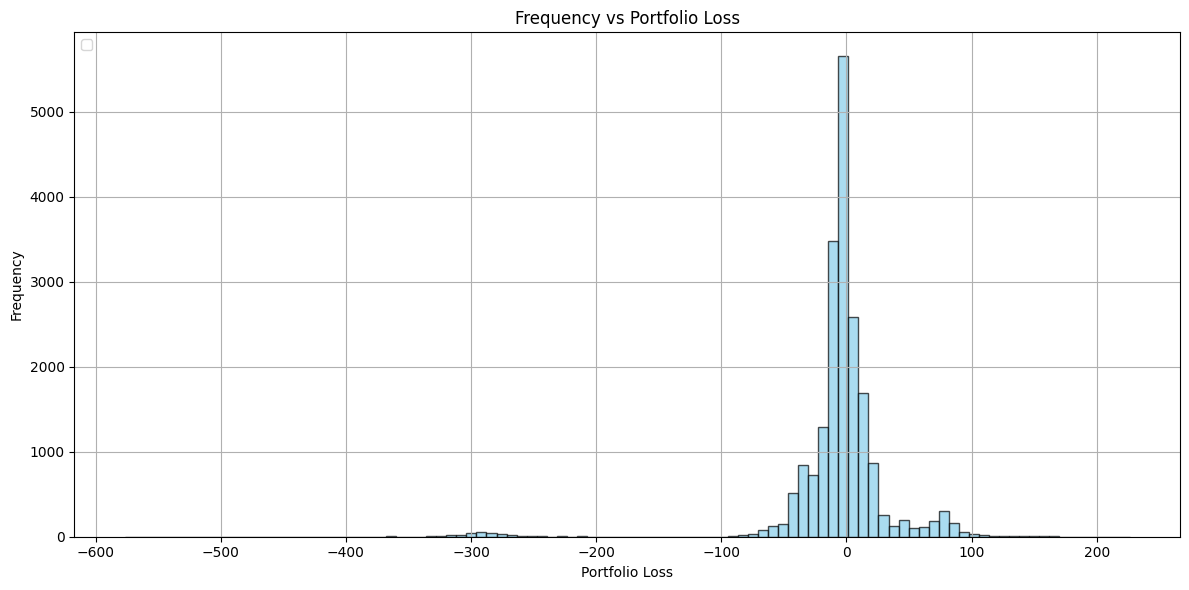

In [151]:
plot_loss_distribution_with_var_cvar(losses,[])

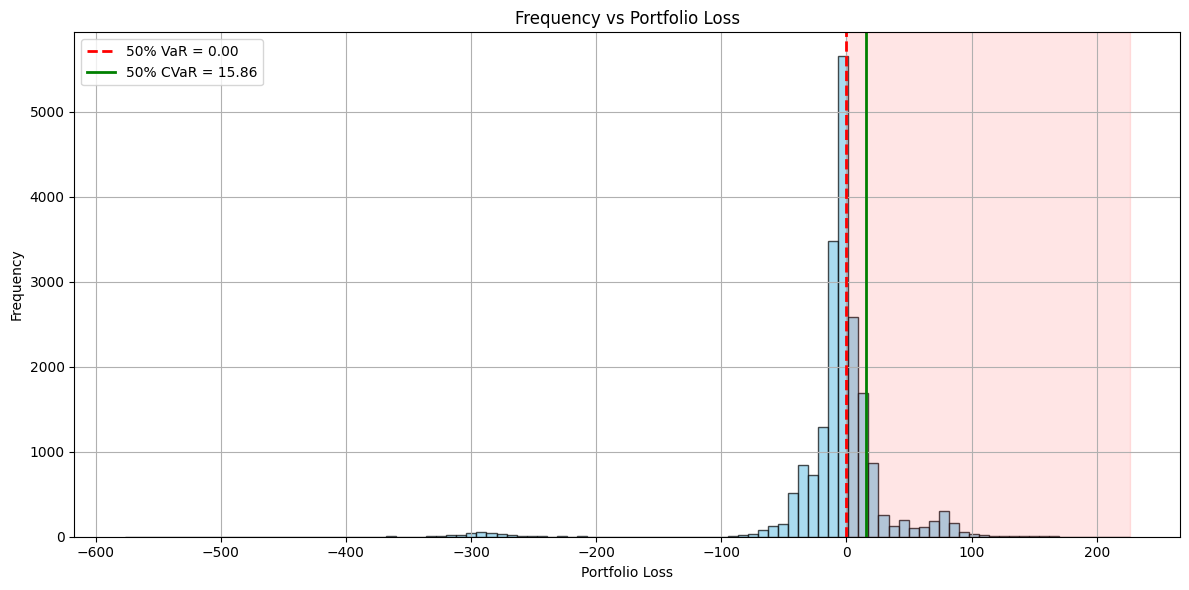

In [152]:
plot_loss_distribution_with_var_cvar(losses,[50])

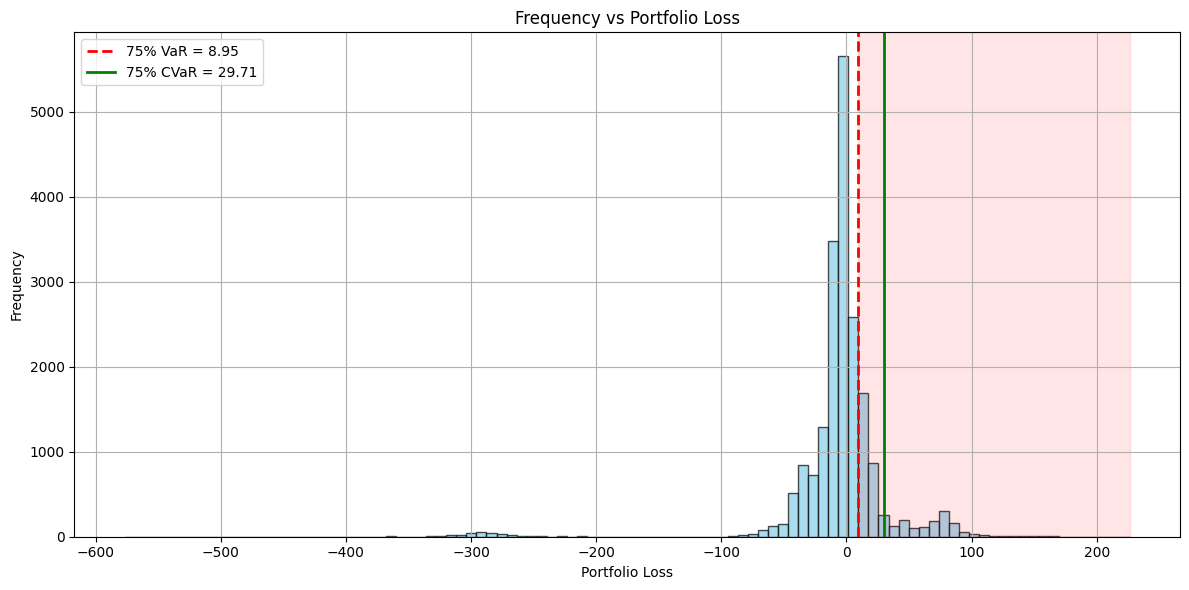

In [153]:
plot_loss_distribution_with_var_cvar(losses,[75])

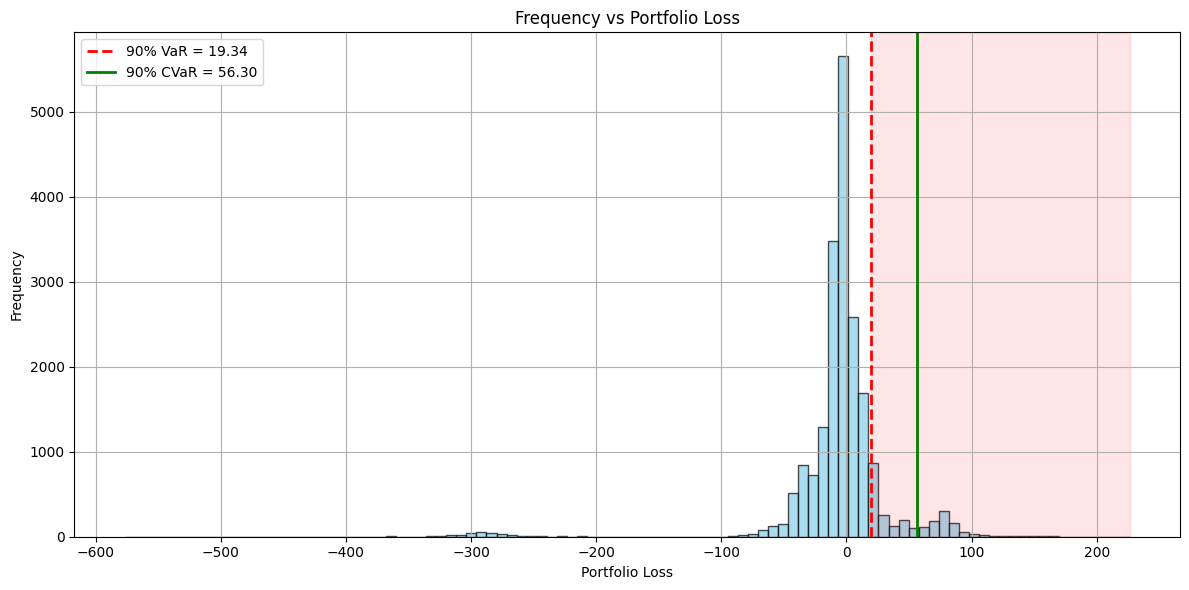

In [154]:
plot_loss_distribution_with_var_cvar(losses,[90])

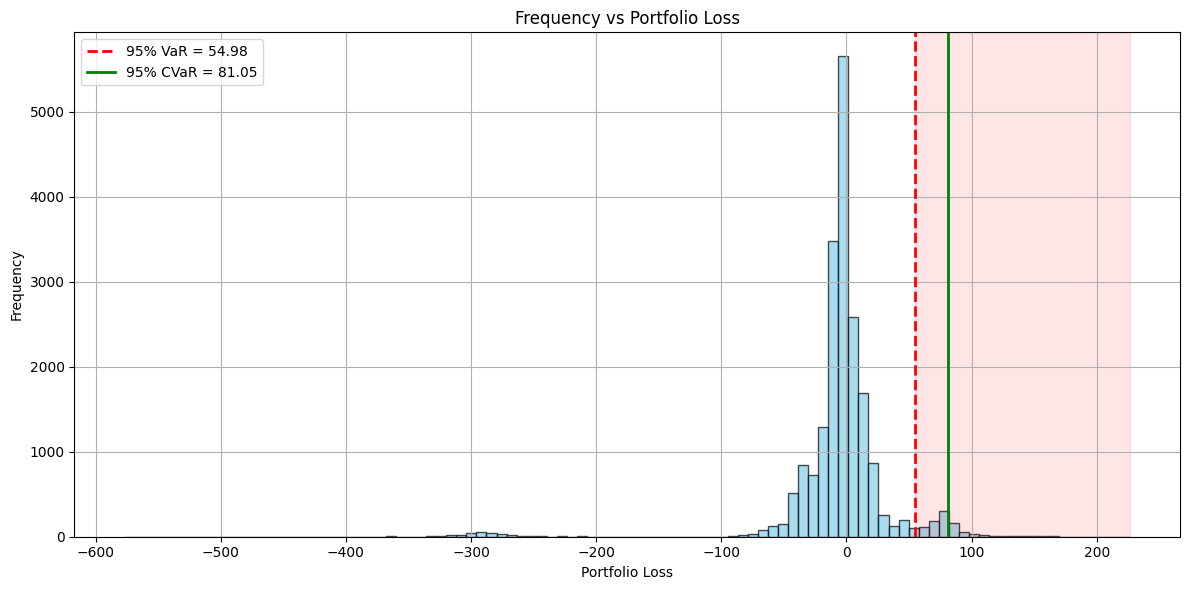

In [155]:
plot_loss_distribution_with_var_cvar(losses,[95])

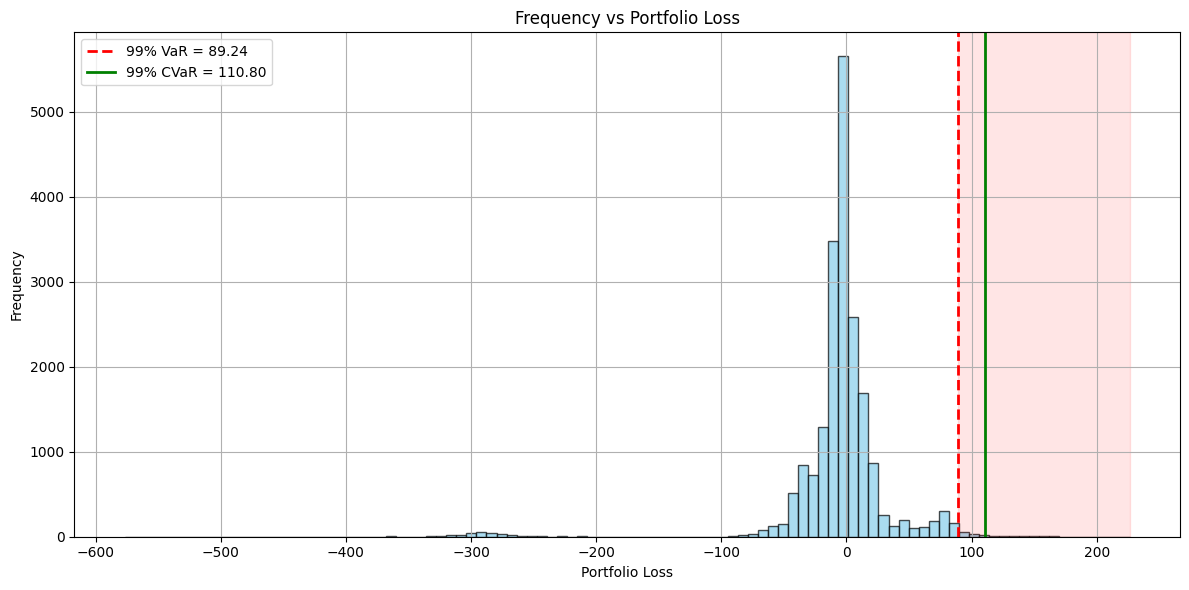

In [156]:
plot_loss_distribution_with_var_cvar(losses,[99])

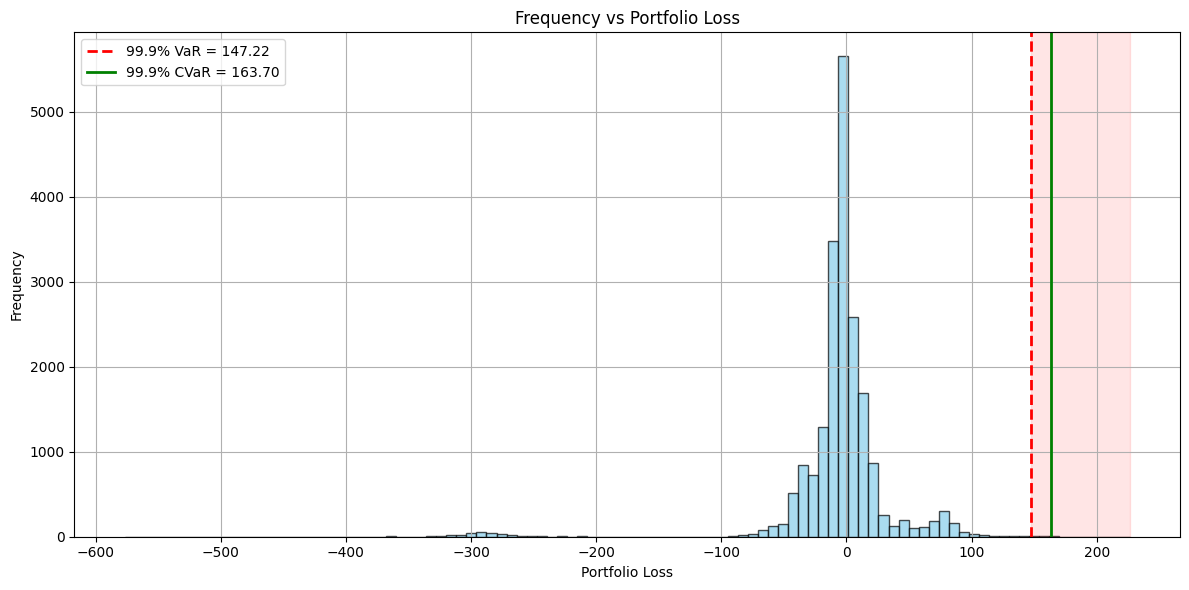

In [157]:
plot_loss_distribution_with_var_cvar(losses,[99.9])

# Linear Programming and Optimisation

In [158]:
 loss_matrix_ = []
 for i in range(len(credit_scenarios_losses)):
    loss_matrix_.append(credit_scenarios_losses[i][0])
 loss_matrix =  np.array(loss_matrix_)

In [159]:
import cvxpy as cp
import numpy as np

def solve_cvar_lp(loss_matrix, q, l_bounds, u_bounds, r=None, R=None, beta=0.99):
    """
    Solves the CVaR optimization problem using the LP formulation.

    Parameters:
        loss_matrix (np.ndarray): Shape (J, n), losses of n assets in J scenarios
        q (np.ndarray): Size n, asset weights (or face values)
        l_bounds (np.ndarray): Lower bounds for x_i
        u_bounds (np.ndarray): Upper bounds for x_i
        r (np.ndarray): Asset returns (if return constraint needed)
        R (float): Required minimum return (optional)
        beta (float): Confidence level for CVaR

    Returns:
        dict: Optimal solution and CVaR
    """
    J, n = loss_matrix.shape
    v = 1 / ((1 - beta) * J)

    # Variables
    x = cp.Variable(n)
    alpha = cp.Variable()
    z = cp.Variable(J)

    # Objective
    objective = cp.Minimize(alpha + v * cp.sum(z))

    # Constraints
    constraints = []

    # (14) z_j ≥ (b_j ⋅ x) - α
    for j in range(J):
        constraints.append(z[j] >= loss_matrix[j] @ x - alpha)

    # (15) z_j ≥ 0
    constraints += [z >= 0]

    # (16) l_i ≤ x_i ≤ u_i
    constraints += [x >= l_bounds, x <= u_bounds]

    # (17) Budget constraint: ∑ q_i x_i = ∑ q_i
    constraints.append(cp.sum(cp.multiply(q, x)) == np.sum(q))

    # (18) Optional return constraint
    if r is not None and R is not None:
        constraints.append(cp.sum(cp.multiply(q * (r - R), x)) >= 0)

    # (19) Concentration constraint: x_i q_i ≤ 20% of ∑ q_i
    for i in range(n):
        constraints.append(x[i] * q[i] <= 0.20 * np.sum(q))

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return {
        "x": x.value,
        "alpha (VaR)": alpha.value,
        "CVaR": prob.value,
        "status": prob.status
    }



In [160]:
# to get a clean value !
def clean_ndarray(arr, tol=1e-5):
    """
    Cleans a NumPy array by setting values with absolute magnitude less than tol to zero.

    Parameters:
        arr (np.ndarray): Input array (any shape).
        tol (float): Tolerance threshold.

    Returns:
        np.ndarray: Cleaned array with near-zero values set to 0.
    """
    return np.where(np.abs(arr) < tol, 0, arr)


In [161]:
# # Suppose you already have:
# # loss_matrix: shape (J, n)
# # q: face values (length n)
# # l_bounds = np.zeros(n)
# # u_bounds = np.ones(n)
# n = loss_matrix.shape[1]
# result = solve_cvar_lp(
#     loss_matrix=loss_matrix,
#     q=bonds_filtered['FACE VALUE \n'].tolist(),
#     l_bounds=np.zeros(n),
#     u_bounds=np.ones(n),
#     # r=your_returns,       # Optional
#     # R=0.01,               # Target return if needed
#     beta=0.99
# )
# print("Optimal weights:", clean_ndarray(result["x"]))
# print("VaR (alpha):", clean_ndarray(result["alpha (VaR)"]))
# print("CVaR:", clean_ndarray(result["CVaR"]))
# # print("Status", clean_ndarray(result['status']))


Optimal weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
VaR (alpha): -1974.306433957981
CVaR: -1952.7457713083477


## Scenario 1
Constriants

1.   xi is non- negative i.e it cannot be shorted.
2.   Also the upper  bound cannot be greater than 2 i.e twice the position hold.



In [162]:
result_no_shorting = solve_cvar_lp(
    loss_matrix=loss_matrix,
    q=bonds_filtered['FACE VALUE \n'].tolist(),
    l_bounds=np.zeros(n),
    u_bounds=np.full(n,2),
    # r=your_returns,       # Optional
    # R=0.01,               # Target return if needed
    beta=0.99
)


Optimal weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
VaR (alpha): -1974.306433957981
CVaR: -1952.7457713083477


In [166]:
print("Optimal weights:", clean_ndarray(result_no_shorting["x"]))
print("VaR (alpha):", clean_ndarray(result_no_shorting["alpha (VaR)"]))
print("CVaR:", clean_ndarray(result_no_shorting["CVaR"]))

Optimal weights: [0.         2.         0.         2.         2.         0.
 2.         0.         2.         2.         2.         0.
 0.         0.         2.         0.         2.         0.
 0.         0.         0.0875915  0.         0.         0.
 0.         0.         2.         2.         1.2514603  2.
 0.         0.         0.         1.36715929 2.         2.
 0.         1.27868704 0.         2.         2.         0.
 0.         2.         2.         0.         2.         2.
 2.         0.         0.         0.01510187 0.         0.        ]
VaR (alpha): -3362.1540586411347
CVaR: -3316.3291464131225


In [163]:
print("Status",result_no_shorting['status'])


Status optimal


## Scenario 2

Constriants

1.   xi can be posititve and negative both.
2.   Also the upper  bound and lower bound cannot be greater than 2 i.e twice the position hold.



In [164]:
result = solve_cvar_lp(
    loss_matrix=loss_matrix,
    q=bonds_filtered['FACE VALUE \n'].tolist(),
    l_bounds=np.full(n,-2),
    u_bounds=np.full(n,2),
    # r=your_returns,       # Optional
    # R=0.01,               # Target return if needed
    beta=0.99
)


Optimal weights: [ 1.41904022  2.         -0.07224621  2.          2.          2.
  2.         -1.03666749  2.          2.          2.         -2.
 -0.60617115  2.          2.         -0.07218314  2.         -0.47683695
 -0.56854091 -0.54764501  2.         -0.07206683 -0.54999143 -0.09548775
 -0.60633455 -0.55296247  2.          2.          2.          2.
  1.37029727  2.         -0.83828474  2.          2.          2.
 -0.47211827  2.         -2.          2.          2.         -0.50205913
 -0.26492669  2.          2.         -0.28031583  2.          2.
  2.         -2.         -0.60565317  2.         -0.47292051 -0.09592526]
VaR (alpha): -3451.2087563563305
CVaR: -3385.250871447445


In [167]:
print("Optimal weights:", clean_ndarray(result["x"]))
print("VaR (alpha):", clean_ndarray(result["alpha (VaR)"]))
print("CVaR:", clean_ndarray(result["CVaR"]))

Optimal weights: [ 1.41904022  2.         -0.07224621  2.          2.          2.
  2.         -1.03666749  2.          2.          2.         -2.
 -0.60617115  2.          2.         -0.07218314  2.         -0.47683695
 -0.56854091 -0.54764501  2.         -0.07206683 -0.54999143 -0.09548775
 -0.60633455 -0.55296247  2.          2.          2.          2.
  1.37029727  2.         -0.83828474  2.          2.          2.
 -0.47211827  2.         -2.          2.          2.         -0.50205913
 -0.26492669  2.          2.         -0.28031583  2.          2.
  2.         -2.         -0.60565317  2.         -0.47292051 -0.09592526]
VaR (alpha): -3451.2087563563305
CVaR: -3385.250871447445


In [165]:
print("Status",result['status'])

Status optimal
